In [1]:
#Run the new window deformation

In [2]:
from openpiv import windef
from openpiv import tools, process, scaling, validation, filters, preprocess
import numpy as np
import os
from time import time
import warnings


import matplotlib.pyplot as plt
%matplotlib inline  

In [3]:
settings = windef.Settings()


'Data related settings'
# Folder with the images to process
settings.filepath_images = '../test1/'
# Folder for the outputs
settings.save_path = '../test1/'
# Root name of the output Folder for Result Files
settings.save_folder_suffix = 'Test_1'
# Format and Image Sequence
settings.frame_pattern_a = 'exp1_001_a.bmp'
settings.frame_pattern_b = 'exp1_001_b.bmp'

'Region of interest'
# (50,300,50,300) #Region of interest: (xmin,xmax,ymin,ymax) or 'full' for full image
settings.ROI = 'full'

'Image preprocessing'
# 'None' for no masking, 'edges' for edges masking, 'intensity' for intensity masking
# WARNING: This part is under development so better not to use MASKS
settings.dynamic_masking_method = 'None'
settings.dynamic_masking_threshold = 0.005
settings.dynamic_masking_filter_size = 7

'Processing Parameters'
settings.correlation_method='circular'  # 'circular' or 'linear'
settings.iterations = 2  # select the number of PIV passes
# add the interroagtion window size for each pass. 
# For the moment, it should be a power of 2 
settings.windowsizes = (64, 32, 16) # if longer than n iteration the rest is ignored
# The overlap of the interroagtion window for each pass.
settings.overlap = (32, 16, 8) # This is 50% overlap
# Has to be a value with base two. In general window size/2 is a good choice.
# methode used for subpixel interpolation: 'gaussian','centroid','parabolic'
settings.subpixel_method = 'gaussian'
# order of the image interpolation for the window deformation
settings.interpolation_order = 3
settings.scaling_factor = 1  # scaling factor pixel/meter
settings.dt = 1  # time between to frames (in seconds)
'Signal to noise ratio options (only for the last pass)'
# It is possible to decide if the S/N should be computed (for the last pass) or not
settings.extract_sig2noise = True  # 'True' or 'False' (only for the last pass)
# method used to calculate the signal to noise ratio 'peak2peak' or 'peak2mean'
settings.sig2noise_method = 'peak2peak'
# select the width of the masked to masked out pixels next to the main peak
settings.sig2noise_mask = 2
# If extract_sig2noise==False the values in the signal to noise ratio
# output column are set to NaN
'vector validation options'
# choose if you want to do validation of the first pass: True or False
settings.validation_first_pass = True
# only effecting the first pass of the interrogation the following passes
# in the multipass will be validated
'Validation Parameters'
# The validation is done at each iteration based on three filters.
# The first filter is based on the min/max ranges. Observe that these values are defined in
# terms of minimum and maximum displacement in pixel/frames.
settings.MinMax_U_disp = (-30, 30)
settings.MinMax_V_disp = (-30, 30)
# The second filter is based on the global STD threshold
settings.std_threshold = 7  # threshold of the std validation
# The third filter is the median test (not normalized at the moment)
settings.median_threshold = 3  # threshold of the median validation
# On the last iteration, an additional validation can be done based on the S/N.
settings.median_size=1 #defines the size of the local median
'Validation based on the signal to noise ratio'
# Note: only available when extract_sig2noise==True and only for the last
# pass of the interrogation
# Enable the signal to noise ratio validation. Options: True or False
settings.do_sig2noise_validation = False # This is time consuming
# minmum signal to noise ratio that is need for a valid vector
settings.sig2noise_threshold = 1.2
'Outlier replacement or Smoothing options'
# Replacment options for vectors which are masked as invalid by the validation
settings.replace_vectors = True # Enable the replacment. Chosse: True or False
settings.smoothn=True #Enables smoothing of the displacemenet field
settings.smoothn_p=0.5 # This is a smoothing parameter
# select a method to replace the outliers: 'localmean', 'disk', 'distance'
settings.filter_method = 'localmean'
# maximum iterations performed to replace the outliers
settings.max_filter_iteration = 4
settings.filter_kernel_size = 2  # kernel size for the localmean method
'Output options'
# Select if you want to save the plotted vectorfield: True or False
settings.save_plot = False
# Choose wether you want to see the vectorfield or not :True or False
settings.show_plot = True
settings.scale_plot = 200  # select a value to scale the quiver plot of the vectorfield
# run the script with the given settings

In [4]:
dir(windef)

['RectBivariateSpline',
 'Settings',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'correlation_func',
 'display_vector_field',
 'fftshift',
 'filters',
 'find_subpixel_peak_position',
 'first_pass',
 'frame_interpolation',
 'get_coordinates',
 'irfft2',
 'multipass_img_deform',
 'np',
 'os',
 'piv',
 'plt',
 'preprocess',
 'process',
 'pyprocess',
 'rfft2',
 'save',
 'scaling',
 'scn',
 'sig2noise_ratio_function',
 'smoothn',
 'tools',
 'validation']

C:\Users\Theo\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


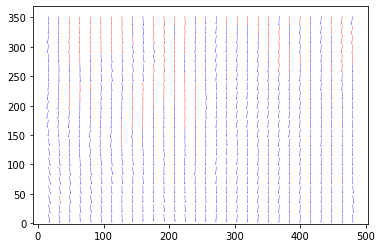

Image Pair 1


In [5]:
windef.piv(settings)

In [6]:
#Run the extended search area PIV

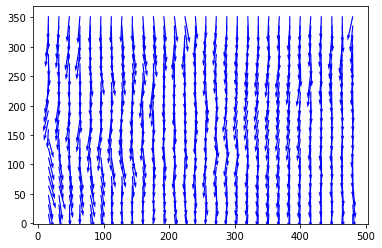

In [7]:


# we can run it from any folder
path = settings.filepath_images


frame_a  = tools.imread( os.path.join(path,settings.frame_pattern_a))
frame_b  = tools.imread( os.path.join(path,settings.frame_pattern_b))

frame_a = (frame_a).astype(np.int32)
frame_b = (frame_b).astype(np.int32)

u, v, sig2noise = process.extended_search_area_piv( frame_a, frame_b, \
    window_size=32, overlap=16, dt=1, search_area_size=64, sig2noise_method='peak2peak' )
x, y = process.get_coordinates( image_size=frame_a.shape, window_size=32, overlap=16 )
u, v, mask = validation.sig2noise_val( u, v, sig2noise, threshold = 1.3 )
u, v, mask = validation.global_val( u, v, (-1000, 2000), (-1000, 1000) )
u, v = filters.replace_outliers( u, v, method='localmean', max_iter=10, kernel_size=2)
x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor = 1)
tools.save(x, y, u, v, mask, 'test1.vec' )
tools.display_vector_field('test1.vec', scale=75, width=0.0035)

In [8]:
#Run the widim

----------------------------------------------------------
|----->     ||   The Open Source  P article              |
| Open      ||                    I mage                 |
|     PIV   ||                    V elocimetry  Toolbox  |
|     <-----||   www.openpiv.net          version 1.0    |
----------------------------------------------------------
 
('Algorithm : ', 'WiDIM')
 
Parameters   
-----------------------------------
('     ', 'Size of image', ' | ', [369, 511])
('     ', 'total number of iterations', ' | ', 3)
('     ', 'overlap ratio', ' | ', 0.0)
('     ', 'coarse factor', ' | ', 2)
('     ', 'time step', ' | ', 1.0)
('     ', 'validation method', ' | ', 'mean_velocity')
('     ', 'number of validation iterations', ' | ', 1)
('     ', 'subpixel_method', ' | ', 'gaussian')
('     ', 'Nrow', ' | ', array([ 5, 11, 23]))
('     ', 'Ncol', ' | ', array([ 7, 15, 31]))
('     ', 'Window sizes', ' | ', array([64, 32, 16]))
-----------------------------------
|           STARTIN

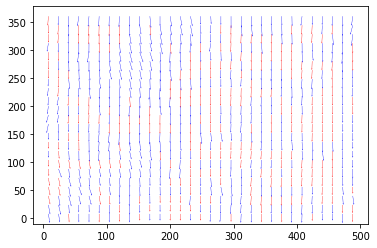

In [9]:


scaling_factor = 1

# we can run it from any folder
path = settings.filepath_images


frame_a  = tools.imread( os.path.join(path,settings.frame_pattern_a))
frame_b  = tools.imread( os.path.join(path,settings.frame_pattern_b))

#no background removal will be performed so 'mark' is initialized to 1 everywhere
mark = np.zeros(frame_a.shape, dtype=np.int32)
for I in range(mark.shape[0]):
    for J in range(mark.shape[1]):
        mark[I,J]=1

#main algorithm
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    x,y,u,v, mask=process.WiDIM( frame_a.astype(np.int32), frame_b.astype(np.int32), mark, min_window_size=16, overlap_ratio=0.0, coarse_factor=2, dt=1, validation_method='mean_velocity', trust_1st_iter=1, validation_iter=1, tolerance=0.7, nb_iter_max=3, sig2noise_method='peak2peak')

#display results
x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor = scaling_factor )

tools.save(x, y, u, v, mask, '2image_00.txt' )

tools.display_vector_field('2image_00.txt',on_img=False, image_name=os.path.join(path,'../test2/2image_00.tif'), window_size=16, scaling_factor=scaling_factor, scale=200, width=0.001)

#further validation can be performed to eliminate the few remaining wrong vectors
